In [80]:
import os, sys

current_dir = os.getcwd()

target_folder = 'polygraphs'

target_path = current_dir[:current_dir.index(target_folder) + len(target_folder)]
sys.path.append(target_path)

In [81]:
from polygraphs.analysis import Processor
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [82]:
processor = Processor(["~/polygraphs-cache/results/"], config_check=False)
print(len(processor.graphs), len(processor.beliefs), len(processor.sims))
print(len(processor.beliefs.graphs[59]), len(processor.graphs[0].nodes), )

60 60 60
13032 13032


In [83]:
processor.graphs[0].pg['ndata']

{'logits': tensor([0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0040]), 'reliability': tensor([1., 1., 1.,  ..., 0., 1., 1.]), 'beliefs': tensor([0.3220, 0.3577, 0.6435,  ..., 0.2982, 0.4416, 0.7701])}

In [84]:
# picking a graph from the available graphs using indexing
graph = processor.graphs[0]

In [101]:
G = nx.read_gml("/Users/prudhvivuda/polygraphs-cache/francisbacon.gml", destringizer=int)
print(len(G))
print(G.nodes[8186])

13032
{'name': 'Sir Thomas Skipwith', 'original_id': 10011164}


## Applying Label Propagation

In [91]:
# Apply Label Propagation Algorithm
lp_communities = nx.algorithms.community.label_propagation_communities(graph)

# Convert generator output to dictionary: {node: community_id}
community_mapping = {}
for community_id, nodes in enumerate(lp_communities):
    for node in nodes:
        community_mapping[node] = community_id

In [92]:
# Convert community mapping to a DataFrame
lp_community_df = pd.DataFrame.from_dict(community_mapping, orient="index", columns=["community"])
lp_community_df.reset_index(inplace=True)
lp_community_df.rename(columns={"index": "node"}, inplace=True)

lp_community_df.to_csv("label_propagation_community_assignments1.csv", index=False)

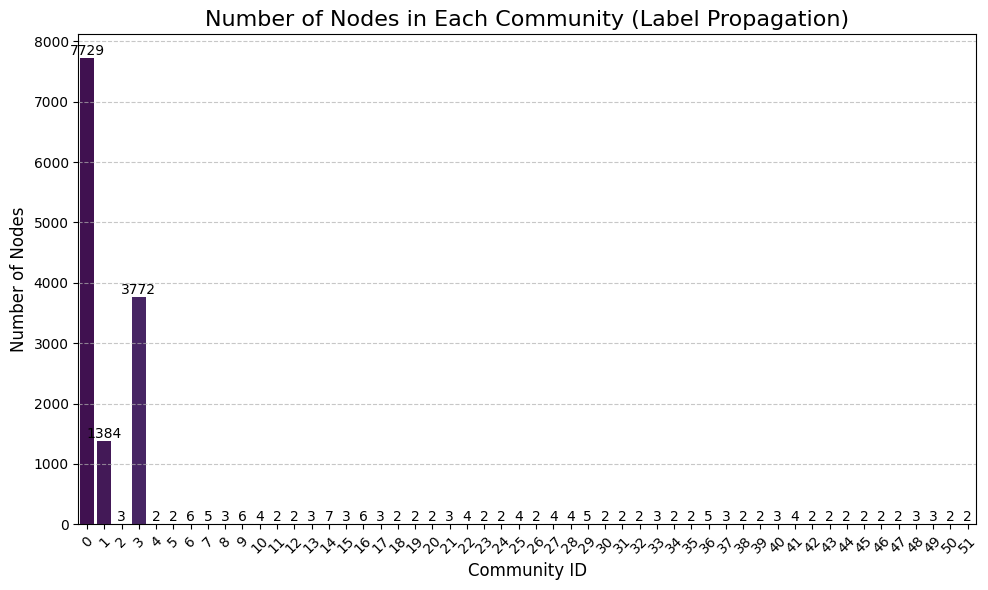

In [93]:
# Count the number of nodes in each community
community_sizes = lp_community_df["community"].value_counts().sort_index()

# Plot a histogram of community sizes
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")

# Add counts on top of each bar
for bar, count in zip(barplot.patches, community_sizes.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Position the text
             str(count), ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Number of Nodes in Each Community (Label Propagation)", fontsize=16)
plt.xlabel("Community ID", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()

# plt.savefig("cd_images/lp nodes in each community.png", format="png", dpi=300, bbox_inches="tight")
# plt.savefig("cd_images/lp nodes in each community.svg", format="svg", bbox_inches="tight")

plt.show()


In [94]:
lp_community_df

,node,community
0,0,0
1,1,0
2,2,0
3,3,0
4,5,0
...,...,...
13027,12917,49
13028,12984,50
13029,12950,50
13030,12968,51


In [95]:
labelled_communities_df = lp_community_df[lp_community_df["community"].isin([0,1,3])]
labelled_communities_df

,node,community
0,0,0
1,1,0
2,2,0
3,3,0
4,5,0
...,...,...
12883,8186,3
12884,8187,3
12885,8188,3
12886,8190,3


In [96]:
labelled_communities_df['groups'] = labelled_communities_df['node'].apply(lambda x: G.nodes[x].get('groups', []))

print(labelled_communities_df)

# dropping groups which doesn't have any groups 
labelled_communities_df = labelled_communities_df[labelled_communities_df['groups'].apply(lambda x: len(x) > 0)]

print(labelled_communities_df)

       node  community     groups
0         0          0  [58, 128]
1         1          0         []
2         2          0         []
3         3          0  [90, 131]
4         5          0         []
...     ...        ...        ...
12883  8186          3         []
12884  8187          3      [130]
12885  8188          3      [130]
12886  8190          3         []
12887  8191          3      [129]

[12885 rows x 3 columns]
       node  community     groups
0         0          0  [58, 128]
3         3          0  [90, 131]
9        11          0      [129]
10       12          0   [8, 131]
14       19          0      [131]
...     ...        ...        ...
12880  8183          3      [130]
12881  8184          3      [130]
12884  8187          3      [130]
12885  8188          3      [130]
12887  8191          3      [129]

[4553 rows x 3 columns]


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_11087/1517798744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_communities_df['groups'] = labelled_communities_df['node'].apply(lambda x: G.nodes[x].get('groups', []))


In [97]:
groups_df = pd.read_csv('/Users/prudhvivuda/Documents/SDFB_groups_2023_04_05.csv') 

# Create a dictionary mapping group ID to group name
group_id_to_name = dict(zip(groups_df['id'], groups_df['name']))

# Function to map group IDs to group names
def map_group_names(group_ids):
    return [group_id_to_name.get(gid, "Unknown") for gid in group_ids]

# Apply the mapping function to the 'groups' column
labelled_communities_df['group_name'] = labelled_communities_df['groups'].apply(map_group_names)

print(labelled_communities_df)


       node  community     groups                              group_name
0         0          0  [58, 128]                    [Puritans, Scholars]
3         3          0  [90, 131]          [English Diplomats, Diplomats]
9        11          0      [129]                             [Composers]
10       12          0   [8, 131]  [Lords of the congregation, Diplomats]
14       19          0      [131]                             [Diplomats]
...     ...        ...        ...                                     ...
12880  8183          3      [130]                                [Actors]
12881  8184          3      [130]                                [Actors]
12884  8187          3      [130]                                [Actors]
12885  8188          3      [130]                                [Actors]
12887  8191          3      [129]                             [Composers]

[4553 rows x 4 columns]


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_11087/1903466502.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_communities_df['group_name'] = labelled_communities_df['groups'].apply(map_group_names)


In [108]:
# Collect Belief Data
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    # _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

In [117]:
beliefs

beliefs  sim                                             op
iteration node                                                               
0         0      0.322007    0       UnreliableNetworkBasicGullibleBinomialOp
          1      0.357743    0       UnreliableNetworkBasicGullibleBinomialOp
          2      0.643538    0       UnreliableNetworkBasicGullibleBinomialOp
          3      0.166924    0       UnreliableNetworkBasicGullibleBinomialOp
          4      0.800937    0       UnreliableNetworkBasicGullibleBinomialOp
...                   ...  ...                                            ...
25000     13027  0.999999   59  UnreliableNetworkModifiedAlignedNegativeEpsOp
          13028       1.0   59  UnreliableNetworkModifiedAlignedNegativeEpsOp
          13029  0.988146   59  UnreliableNetworkModifiedAlignedNegativeEpsOp
          13030  0.999997   59  UnreliableNetworkModifiedAlignedNegativeEpsOp
          13031  0.894238   59  UnreliableNetworkModifiedAlignedNegativeEpsOp

[197043840 rows x 3 columns]

In [123]:
blfs = beliefs.reset_index()

In [124]:
blfs

,iteration,node,beliefs,sim,op
0,0,0,0.322007,0,UnreliableNetworkBasicGullibleBinomialOp
1,0,1,0.357743,0,UnreliableNetworkBasicGullibleBinomialOp
2,0,2,0.643538,0,UnreliableNetworkBasicGullibleBinomialOp
3,0,3,0.166924,0,UnreliableNetworkBasicGullibleBinomialOp
4,0,4,0.800937,0,UnreliableNetworkBasicGullibleBinomialOp
...,...,...,...,...,...
197043835,25000,13027,0.999999,59,UnreliableNetworkModifiedAlignedNegativeEpsOp
197043836,25000,13028,1.0,59,UnreliableNetworkModifiedAlignedNegativeEpsOp
197043837,25000,13029,0.988146,59,UnreliableNetworkModifiedAlignedNegativeEpsOp
197043838,25000,13030,0.999997,59,UnreliableNetworkModifiedAlignedNegativeEpsOp


In [ ]:
import pandas as pd

def compute_group_belief_stats(beliefs, labelled_communities_df, group_number):
    """
    Extracts beliefs for a given group number and computes:
    - Mean of group means
    - Median of group medians
    - Both per simulation (sim by sim) and across simulations (aggregated by 'op').

    Parameters:
    - beliefs (pd.DataFrame): DataFrame containing belief data with 'sim' and 'op'.
    - labelled_communities_df (pd.DataFrame): DataFrame mapping nodes to groups and communities.
    - group_number (int): The group number to filter beliefs by.

    Returns:
    - results (dict): Dictionary with mean and median statistics.
    """
    
    # Get nodes belonging to the given group number
    nodes_in_group = labelled_communities_df[labelled_communities_df['groups'].apply(lambda x: group_number in x)]['node'].tolist()

    # Filter beliefs for selected nodes
    group_beliefs = beliefs[beliefs['node'].isin(nodes_in_group)]
    
    # Compute stats per simulation
    sim_stats = group_beliefs.groupby(["sim", "op"])['beliefs'].agg(['mean', 'median', 'std', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).reset_index()
    sim_stats.columns = ['sim', 'op', 'mean', 'median', 'std', 'min', 'max', 'quantile_25', 'quantile_75']

    # Compute mean of means and median of medians across simulations
    aggregated_stats = sim_stats.groupby("op").agg(
            mean=('mean', 'mean'),
            median=('median', 'median'),
            std=('std', 'mean'),
            min=('min', 'mean'),
            max=('max', 'mean'),
            quantile_25=('quantile_25', 'mean'),
            quantile_75=('quantile_75', 'mean')
        ).reset_index()

    # Return results as a dictionary
    return {
        'sim_stats': sim_stats,          # Sim-by-sim statistics
        'aggregated_stats': aggregated_stats  # Aggregated across sims
    }

# Example usage:
results = compute_group_belief_stats(blfs, labelled_communities_df, group_number=65)
sim_by_sim_stats = results['sim_stats']
aggregated_stats = results['aggregated_stats']


In [162]:
sim_by_sim_stats

,sim,op,mean,median,std,min,max,quantile_25,quantile_75
0,0,UnreliableNetworkBasicGullibleBinomialOp,0.891501,1.0,0.271606,0.000013,1.0,0.999998,1.0
1,1,UnreliableNetworkBasicGullibleBinomialOp,0.955073,1.0,0.156052,0.00101,1.0,0.999999,1.0
2,2,UnreliableNetworkBasicGullibleBinomialOp,0.961853,1.0,0.156544,0.000385,1.0,1.0,1.0
3,3,UnreliableNetworkBasicGullibleBinomialOp,0.957944,1.0,0.156576,0.000595,1.0,0.999998,1.0
4,4,UnreliableNetworkBasicGullibleBinomialOp,0.933499,1.0,0.213582,0.000324,1.0,0.999997,1.0
5,5,UnreliableNetworkModifiedAlignedBinomialOp,0.919376,0.999999,0.214867,0.004969,1.0,0.999554,1.0
6,6,UnreliableNetworkModifiedAlignedBinomialOp,0.965092,1.0,0.130778,0.014403,1.0,0.999988,1.0
7,7,UnreliableNetworkModifiedAlignedBinomialOp,0.945934,1.0,0.184653,0.001427,1.0,0.999963,1.0
8,8,UnreliableNetworkModifiedAlignedBinomialOp,0.952967,1.0,0.161015,0.010804,1.0,0.999993,1.0
9,9,UnreliableNetworkModifiedAlignedBinomialOp,0.948263,1.0,0.186235,0.000481,1.0,0.999965,1.0


In [163]:
aggregated_stats

,op,mean,median,std,min,max,quantile_25,quantile_75
0,BalaGoyalOp,0.963669,1.0,0.140927,0.015667,1.0,1.0,1.0
1,UnreliableNetworkBasicGullibleBinomialOp,0.938281,1.0,0.194541,0.00045,1.0,0.99999,1.0
2,UnreliableNetworkBasicGullibleNegativeEpsOp,0.903961,1.0,0.25446,0.000674,1.0,0.997846,1.0
3,UnreliableNetworkIdealOp,0.946795,1.0,0.180336,0.002644,1.0,0.999998,1.0
4,UnreliableNetworkModifiedAlignedBinomialOp,0.944053,1.0,0.180301,0.005499,1.0,0.999911,1.0
5,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.876823,0.999995,0.263607,0.001953,1.0,0.928619,1.0


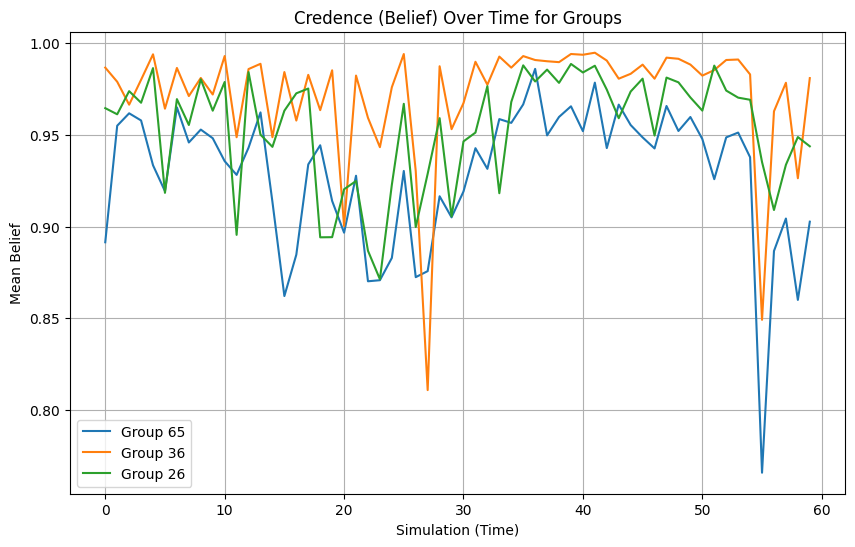

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_credence_over_time(beliefs, labelled_communities_df, group_numbers):
    """
    Plots the credence (belief) over time for the specified group numbers.

    Parameters:
    - beliefs (pd.DataFrame): DataFrame containing belief data with 'sim' and 'op'.
    - labelled_communities_df (pd.DataFrame): DataFrame mapping nodes to groups and communities.
    - group_numbers (list of int): The group numbers to filter and plot.
    """
    plt.figure(figsize=(10, 6))

    for group_number in group_numbers:
        # Get nodes belonging to the given group number
        nodes_in_group = labelled_communities_df[
            labelled_communities_df['groups'].apply(lambda x: group_number in x)
        ]['node'].tolist()

        # Filter beliefs for selected nodes
        group_beliefs = beliefs[beliefs['node'].isin(nodes_in_group)]

        # Compute mean belief for each simulation
        group_beliefs_mean = group_beliefs.groupby(['sim'])['beliefs'].mean()

        # Plot the mean belief over time
        plt.plot(group_beliefs_mean.index, group_beliefs_mean.values, label=f'Group {group_number}')

    # Customize the plot
    plt.title('Credence (Belief) Over Time for Groups')
    plt.xlabel('Simulation (Time)')
    plt.ylabel('Mean Belief')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage:
royal_society = 65
royal_society_founding_members = 36
cavalier_poets = 26
plot_credence_over_time(blfs, labelled_communities_df, group_numbers=[royal_society, royal_society_founding_members, cavalier_poets])
